In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)

from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [128]:
data = pd.read_csv('./cleaned_data.csv')
data.columns

Index(['SubscriptionId', 'InvestorId', 'ProductId', 'ProductCategory',
       'LoanApplicationId', 'IsFinalPayBack', 'IsThirdPartyConfirmed',
       'num_loan', 'num_batch', 'last_payment_late', 'PaidLate',
       'IsDefaulted'],
      dtype='object')

### PREPROCESSING.

In [129]:
data.loc[data['ProductCategory'].value_counts()[data['ProductCategory']].values < 100, 'ProductCategory'] = '_-1'
data.loc[data['InvestorId'].value_counts()[data['InvestorId']].values < 500, 'InvestorId'] = '_-1'
data.loc[data['ProductId'].value_counts()[data['ProductId']].values < 100, 'ProductId'] = '_-1'
data.loc[data['SubscriptionId'].value_counts()[data['SubscriptionId']].values < 200, 'SubscriptionId'] = '_-1'

In [130]:
catcols = ['SubscriptionId', 'InvestorId', 'ProductId', 'ProductCategory', 'LoanApplicationId']

for col in catcols:     
       
       data[col] = [x.split('_')[-1] for x in data[col]]

mapping_dict = {entry:x for x, entry in enumerate(data['ProductCategory'])}
data['ProductCategory'] = data['ProductCategory'].map(mapping_dict)

data['PaidLate'] = data['PaidLate'].map({True:1, False:0})



cat_cols = ['SubscriptionId', 'ProductCategory', 'InvestorId', 'ProductId']
for col in cat_cols:
   
    column = [col+str(i) for i in data[col].unique()]
    dummies = pd.get_dummies(data[col], prefix=col+'_', dtype='int32')
    #data.drop(col, axis=1, inplace=True)
    data = pd.concat([data, dummies], axis=1)
data = data.drop(cat_cols, axis=1)

In [132]:
data.head()

,LoanApplicationId,IsFinalPayBack,IsThirdPartyConfirmed,num_loan,num_batch,last_payment_late,PaidLate,IsDefaulted,SubscriptionId__-1,SubscriptionId__6,SubscriptionId__7,ProductCategory__1423,ProductCategory__1467,ProductCategory__1477,ProductCategory__1478,InvestorId__-1,InvestorId__1,ProductId__-1,ProductId__18,ProductId__3,ProductId__4,ProductId__7
0,1629,1,0,39,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1
1,136,1,0,2,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1
2,1171,1,0,10,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1
3,702,1,0,10,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1
4,508,1,0,10,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0


### MODELLING.

In [134]:
X = data.drop(['IsDefaulted', 'LoanApplicationId', 'PaidLate', 'num_loan'], axis=1)
y = data.IsDefaulted

skf = StratifiedKFold(n_splits=3, random_state=23, shuffle=True)

In [135]:
dt = DecisionTreeClassifier(random_state=23, class_weight='balanced', max_depth=4)

def model(dt):
    for fold_, (train_ind, valid_ind) in enumerate(skf.split(X, y)):
        trainx = X.iloc[train_ind, :]
        validx = X.iloc[valid_ind, :]

        trainy = y[train_ind]
        validy = y[valid_ind]

        dt.fit(trainx, trainy)
        tpred = dt.predict(trainx)

        print(f'Fold : {fold_}')
        print('Training scores.')
        print(f'F1 score : {f1_score(trainy, tpred)}')
        print(f'ROC AUC Score : {roc_auc_score(trainy, tpred)}')
        print('-'*50)

        vpred = dt.predict(validx)
        print('Validating scores.')

        print(f'F1 score : {f1_score(validy, vpred)}')
        print(f'ROC AUC Score : {roc_auc_score(validy, vpred)}')
        print('-'*100)

model(dt=dt)

Fold : 0
Training scores.
F1 score : 0.7564102564102563
ROC AUC Score : 0.956221198156682
--------------------------------------------------
Validating scores.
F1 score : 0.7891156462585034
ROC AUC Score : 0.9643678160919541
----------------------------------------------------------------------------------------------------
Fold : 1
Training scores.
F1 score : 0.8715953307392997
ROC AUC Score : 0.9625220068258042
--------------------------------------------------
Validating scores.
F1 score : 0.8333333333333333
ROC AUC Score : 0.945364367726314
----------------------------------------------------------------------------------------------------
Fold : 2
Training scores.
F1 score : 0.8615384615384616
ROC AUC Score : 0.9607958848465178
--------------------------------------------------
Validating scores.
F1 score : 0.8549618320610687
ROC AUC Score : 0.9561430914629384
----------------------------------------------------------------------------------------------------


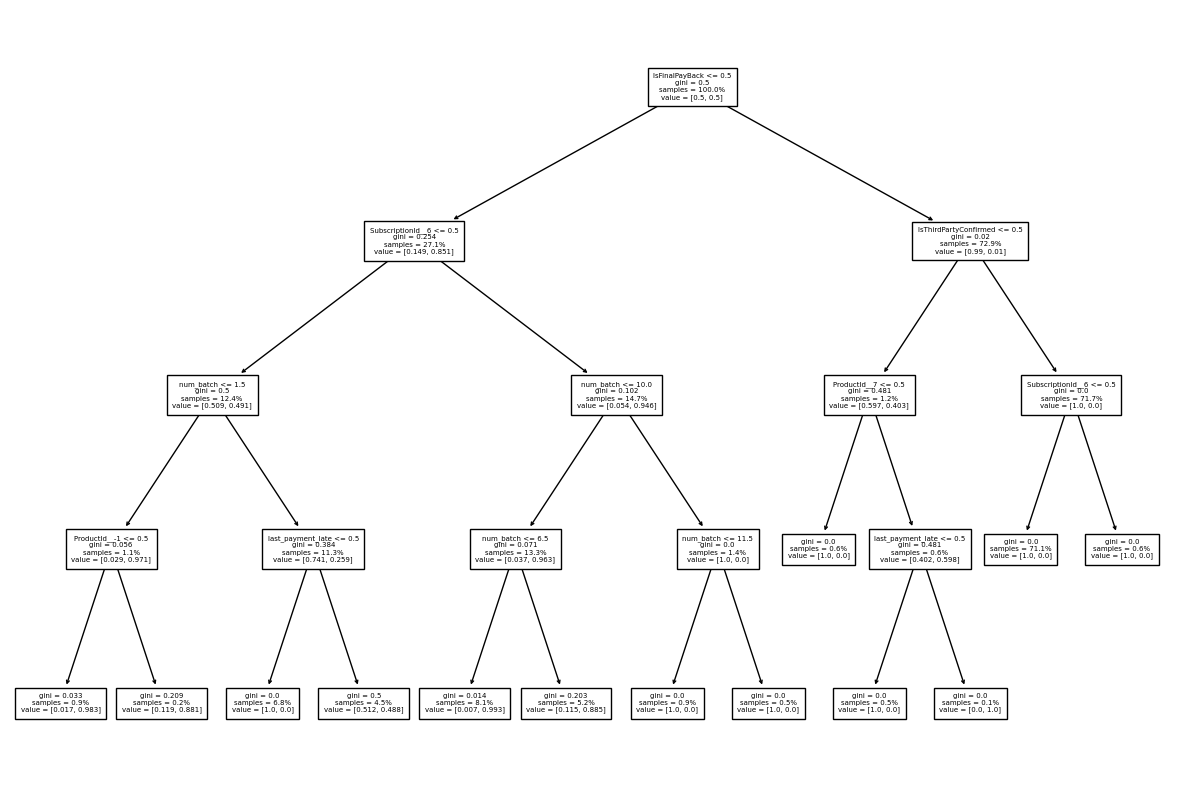

In [146]:
from sklearn import tree
plt.figure(figsize=(15, 10))
tree.plot_tree(dt, feature_names= X.columns, proportion=True, fontsize=5)
plt.savefig('./loan-default-decision-tree.png')
plt.show()


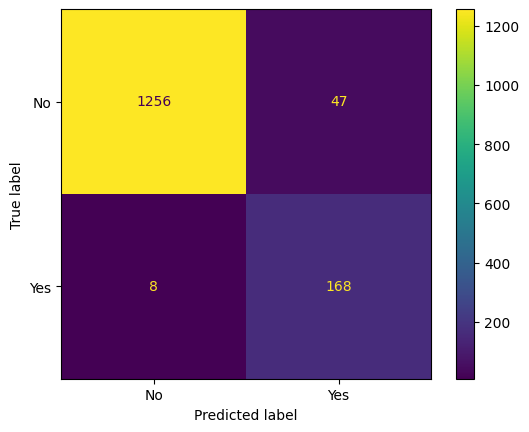

In [137]:
cm = confusion_matrix(y, dt.predict(X), labels=[0,1])
dist = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
dist.plot()
plt.show()

In [149]:
rf = RandomForestClassifier(n_estimators=100, random_state=23, class_weight='balanced', criterion='log_loss', oob_score=True, n_jobs=-1)

model(dt=rf)

Fold : 0
Training scores.
F1 score : 0.8634686346863468
ROC AUC Score : 0.9750253846754667
--------------------------------------------------
Validating scores.
F1 score : 0.8702290076335878
ROC AUC Score : 0.9729885057471265
----------------------------------------------------------------------------------------------------
Fold : 1
Training scores.
F1 score : 0.8914728682170542
ROC AUC Score : 0.9764932676325081
--------------------------------------------------
Validating scores.
F1 score : 0.7656250000000001
ROC AUC Score : 0.8922127626337577
----------------------------------------------------------------------------------------------------
Fold : 2
Training scores.
F1 score : 0.8656716417910448
ROC AUC Score : 0.9755884059681529
--------------------------------------------------
Validating scores.
F1 score : 0.8358208955223881
ROC AUC Score : 0.9526868702647817
----------------------------------------------------------------------------------------------------


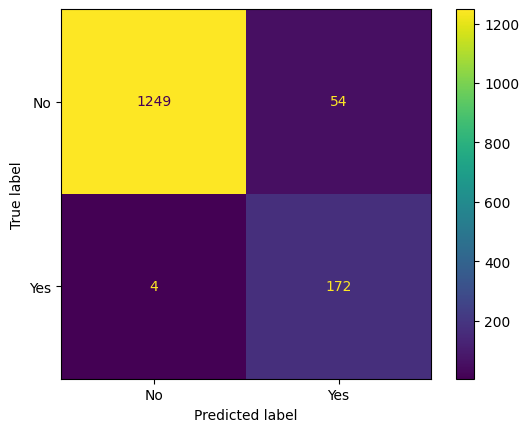

In [150]:
cm = confusion_matrix(y, rf.predict(X), labels=[0,1])
dist = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])
dist.plot()
plt.show()

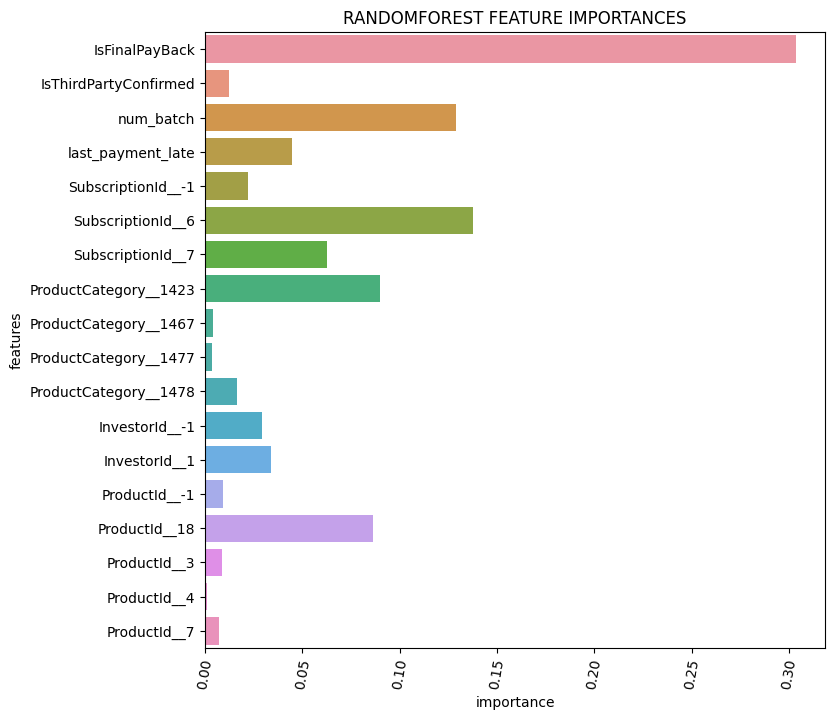

In [151]:
# show_importance(rf.feature_importances_)
importances = pd.DataFrame({'importance':rf.feature_importances_, 'features':X.columns})
# importances.bar()
plt.figure(figsize=(8,8))
sns.barplot(data=importances, y='features', x='importance')
plt.xticks(rotation=80)
plt.title('RANDOMFOREST FEATURE IMPORTANCES')
plt.savefig('./feature-importances', )
plt.show()